This notebook contains results and experiments with C-SWM

## Number of objects
Train parameters
- Batch size = 512
- Encoder = Large
- Hidden dim = 512
- Embedding dim = 10
- Num_objects = ?
- Epochs = 10 and 20
- Learning rate 5e-4

Evaluation parameters:
- Linear: 2000 iterations
- Fine tuning 30 and 60 epochs
- 10% of MNIST train labels
- Use transition model or not
- Ranking metrics 1,5 and 10 steps

How to visualize the results: Isolate result curves for each of the evaluation parameters. 

*We are testing for different number of epochs to evaluate correlation between variables and to check if we can get significant results with fewer epochs.

How to evaluate quantitatively => Pearson correlation

In [328]:
import matplotlib
#From https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [372]:
import ast
import torch
from torch import tensor
import copy
import numpy as np
    
'''
Function that extracts results from the results file.
Results contain the results for specific experiments for specific parameters, encoded in a dict
Return: result_list{sub_dict['experiment']: result, [param]: value}
The order of the params matters
'''
def extract_results(file_path):
    file_list = []
    with open(file_path, "r") as f:
        for line in f:
            file_list.append(line[:-1])
    
    result_list = []
    i = -1
    temp_dict = None
    while i < len(file_list)-1:
        i += 1
        if len(file_list[i]) == 0:
            continue
        elif file_list[i][0:4] == '----':
            continue
        elif file_list[i][0] == '{':
            if not temp_dict is None:
                result_list.append(temp_dict)
            #Get train parameters
            temp_dict = eval(file_list[i])
        elif file_list[i][0:15] == "use_trans_model":
            #Get if uses trans model and add to dict
            temp_dict['use_trans_model'] = file_list[i].split("=")[1]
        elif file_list[i][0:9] == 'num_steps':
            num_steps = file_list[i].split('=')[1]
            i += 2
            res_steps_dict = eval(file_list[i])
            temp_dict['H1_num_steps='+str(num_steps)] = res_steps_dict['H1']
            temp_dict['MRR_num_steps='+str(num_steps)] = res_steps_dict['MRR'].item()
        else:
            split_line = file_list[i].split(" = ")
            temp_dict[split_line[0]] = float(split_line[1])

    return result_list

'''
Convert dict to a param key
'''
def dict_to_key(dict_target, ignore_keys):
    dict_copy = copy.deepcopy(dict_target)
    for key in ignore_keys:
        if key in dict_copy:
            del dict_copy[key]
    return str(dict_copy)

'''
Initializes the dictionary for certain parameters
'''
def init_result_dict(experiment_keys, varying_param):
    result_dict = {}
    for exp_key in experiment_keys:
        result_dict[exp_key] = {"result": [], varying_param: []}
    return result_dict

'''
Extracts results arrays for a specific varying param, one for each pair of fixed params and experiment
varying_param => Parameter that is being altered at every iteration
experiments_keys => dict keys that are the experiments
keys that are not experiment or varying are considered fixed
Returns a dictionary(fixed parameters) of dictionary(experiments) of lists(results) + list(varying_param_value)
'''
def get_results_array(result_list, varying_param, experiment_keys, ignore_keys):
    final_dict = {}
    for result_dict in result_list:
        param_key = dict_to_key(result_dict, [varying_param] + experiment_keys + ignore_keys)
        if not param_key in final_dict:
            final_dict[param_key] = init_result_dict(experiment_keys, varying_param)
        for exp_key in experiment_keys:
            if exp_key in result_dict:
                final_dict[param_key][exp_key][varying_param].append(result_dict[varying_param])
                final_dict[param_key][exp_key]['result'].append(result_dict[exp_key])
    return final_dict

'''
Uses a list of parameters to return the key to a result dictionary for certain parameters values
Warns if there is a duplicate
'''
def get_param_key(params, values, results):
    found = False
    found_key = None
    for key in results.keys():
        key_dict = eval(key)
        hits = 0
        for param, value in zip(params, values):
            if key_dict[param] == value:
                hits += 1
        if hits == len(params):
            if found == True:
                print("Duplicate")
                print(found_key)
                print(key)
                return None
            found = True
            found_key = key
    return found_key

'''
Processes two lists (x, y), given mean and std dev values
Returns 3 lists: x , y_mean, y_std_dev
'''
def get_mean_std_dev(xs, ys):
    #use np
    aux_dict = {}
    for x,y in zip(xs, ys):
        if not x in aux_dict:
            aux_dict[x] = []
        aux_dict[x].append(y)

    x_out = []
    y_mean = []
    y_std = []
    for x in aux_dict.keys():
        x_out.append(x)
        y_mean.append(np.asarray(aux_dict[x]).mean())
        y_std.append(np.asarray(aux_dict[x]).std())
    return x_out, y_mean, y_std

'''
Function to simplify plotting pipeline
'''
def get_plot_ready_res(results, params, values, experiment_key, varying_param):
    found_key = get_param_key(params, values, results)
    x, y_mean, y_std = get_mean_std_dev(results[found_key][experiment_key][varying_param], results[found_key][experiment_key]['result'])
    indexes = list(range(len(x)))
    indexes.sort(key=x.__getitem__)
    x = list(map(x.__getitem__, indexes))
    y_mean = list(map(y_mean.__getitem__, indexes))
    y_std = list(map(y_std.__getitem__, indexes))
    return x, y_mean, y_std

'''
Generates Pearson Correlation Matrix
Variables(experiments) are in the order given by experiment_keys
'''
def generate_pearson_corr_mat(results, params, values, experiment_keys, varying_param):
    found_key = get_param_key(params, values, results)
    res_matrix = None
    for experiment_key in experiment_keys:
        x, y_mean, y_std = get_mean_std_dev(results[found_key][experiment_key][varying_param], results[found_key][experiment_key]['result'])
        y_mean = np.asarray(y_mean).reshape(1, len(y_mean))
        if res_matrix is None:
            res_matrix = np.asarray(y_mean)
        else:
            res_matrix = np.concatenate((res_matrix, np.asarray(y_mean)), axis=0)
    return np.corrcoef(res_matrix)


'''
Generates a results matrix ready for Pearson Correlation operation
Variables(experiments) are in the order given by experiment_keys
'''
def generate_results_mat(results, params, values, experiment_keys, varying_param):
    found_key = get_param_key(params, values, results)
    res_matrix = None
    for experiment_key in experiment_keys:
        x, y_mean, y_std = get_mean_std_dev(results[found_key][experiment_key][varying_param], results[found_key][experiment_key]['result'])
        y_mean = np.asarray(y_mean).reshape(1, len(y_mean))
        if res_matrix is None:
            res_matrix = np.asarray(y_mean)
        else:
            res_matrix = np.concatenate((res_matrix, np.asarray(y_mean)), axis=0)
    return res_matrix

In [316]:
experiment_keys = ['LinearEvalAcc', 'FineTuning10pc30epochs', 'FineTuning10pc60epochs']
experiment_keys += ['H1_num_steps=1', 'H1_num_steps=5', 'H1_num_steps=10']
experiment_keys += ['MRR_num_steps=1', 'MRR_num_steps=5', 'MRR_num_steps=10']
varying_param = 'num_objects'
result_list = extract_results("results/eval_num_objects.txt")
ignore_keys = ['seed']
results = get_results_array(result_list, varying_param, experiment_keys, ignore_keys)

In [317]:
results

{"{'batch_size': 512, 'epochs': 10, 'learning_rate': 0.0005, 'encoder': 'large', 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'embedding_dim': 10, 'action_dim': 4, 'ignore_action': True, 'copy_action': False, 'decoder': False, 'no_cuda': False, 'log_interval': 20, 'dataset': '/datasets/c_swm_data/mmnist_train.h5', 'name': 'mmnist', 'save_folder': 'checkpoints', 'cuda': True, 'use_trans_model': 'False'}": {'LinearEvalAcc': {'result': [0.2847,
    0.3899,
    0.4188,
    0.6198,
    0.5059,
    0.4684,
    0.3448,
    0.4264,
    0.5237,
    0.5467,
    0.4855,
    0.4742,
    0.3102,
    0.2974,
    0.3306,
    0.3263,
    0.3173,
    0.387,
    0.4799,
    0.5404,
    0.4478],
   'num_objects': [2,
    5,
    10,
    15,
    20,
    25,
    2,
    5,
    10,
    15,
    20,
    25,
    2,
    2,
    2,
    2,
    2,
    5,
    10,
    15,
    15]},
  'FineTuning10pc30epochs': {'result': [0.3338,
    0.806,
    0.71,
    0.7735,
    0.8768,
    0.762,
    0.2584,
    0.5726,
    0.787

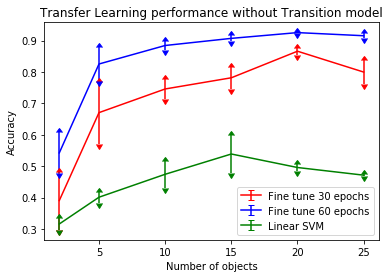

In [354]:
params = ['epochs', 'use_trans_model']
values = [10, 'False']
#30 epochs
experiment_key = 'FineTuning10pc30epochs'
varying_param = 'num_objects'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='r', label='Fine tune 30 epochs')
#60 epochs
experiment_key = 'FineTuning10pc60epochs'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='b', label='Fine tune 60 epochs')
#Linear eval
experiment_key = 'LinearEvalAcc'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='g', label='Linear SVM')

plt.xlabel('Number of objects')
plt.ylabel('Accuracy')
plt.title('Transfer Learning performance without Transition model')
plt.legend()
plt.show()

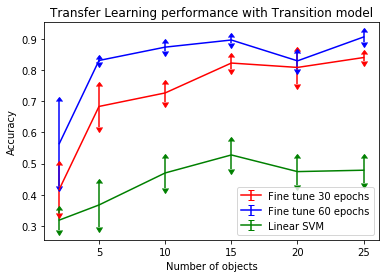

In [357]:
params = ['epochs', 'use_trans_model']
values = [10, 'True']
#30 epochs
experiment_key = 'FineTuning10pc30epochs'
varying_param = 'num_objects'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='r', label='Fine tune 30 epochs')
#60 epochs
experiment_key = 'FineTuning10pc60epochs'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='b', label='Fine tune 60 epochs')
#Linear eval
experiment_key = 'LinearEvalAcc'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='g', label='Linear SVM')

plt.xlabel('Number of objects')
plt.ylabel('Accuracy')
plt.title('Transfer Learning performance with Transition model')
plt.legend()
plt.show()

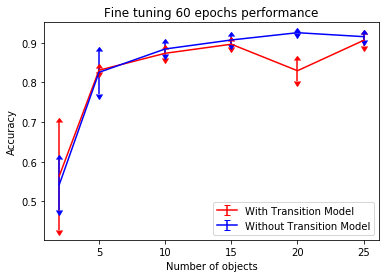

In [370]:
#With
params = ['epochs', 'use_trans_model']
values = [10, 'True']
experiment_key = 'FineTuning10pc60epochs'
varying_param = 'num_objects'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='r', label='With Transition Model')
#Without
params = ['epochs', 'use_trans_model']
values = [10, 'False']
experiment_key = 'FineTuning10pc60epochs'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='b', label='Without Transition Model')


plt.xlabel('Number of objects')
plt.ylabel('Accuracy')
plt.title('Fine tuning 60 epochs performance')
plt.legend()
plt.show()

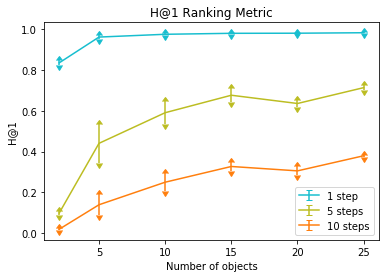

In [365]:
params = ['epochs', 'use_trans_model']
values = [10, 'True']
#30 epochs
experiment_key = 'H1_num_steps=1'
varying_param = 'num_objects'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='tab:cyan', label='1 step')
#60 epochs
experiment_key = 'H1_num_steps=5'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='tab:olive', label='5 steps')
#Linear eval
experiment_key = 'H1_num_steps=10'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='tab:orange', label='10 steps')

plt.xlabel('Number of objects')
plt.ylabel('H@1')
plt.title('H@1 Ranking Metric')
plt.legend()
plt.show()

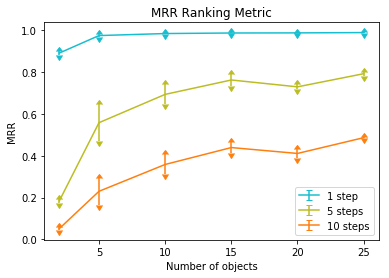

In [366]:
params = ['epochs', 'use_trans_model']
values = [10, 'True']
#30 epochs
experiment_key = 'MRR_num_steps=1'
varying_param = 'num_objects'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='tab:cyan', label='1 step')
#60 epochs
experiment_key = 'MRR_num_steps=5'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='tab:olive', label='5 steps')
#Linear eval
experiment_key = 'MRR_num_steps=10'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='tab:orange', label='10 steps')

plt.xlabel('Number of objects')
plt.ylabel('MRR')
plt.title('MRR Ranking Metric')
plt.legend()
plt.show()

<ErrorbarContainer object of 3 artists>

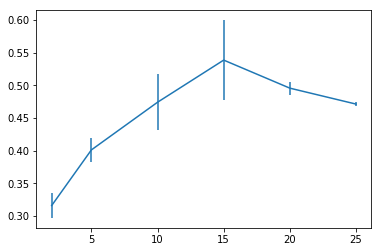

In [320]:
import matplotlib.pyplot as plt
params = ['epochs', 'use_trans_model']
values = [10, 'False']
experiment_key = 'LinearEvalAcc'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std)

<ErrorbarContainer object of 3 artists>

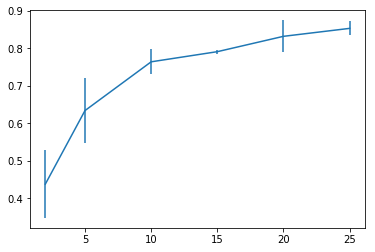

In [325]:
params = ['epochs', 'use_trans_model']
values = [20, 'True']
experiment_key = 'FineTuning10pc30epochs'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std)

<ErrorbarContainer object of 3 artists>

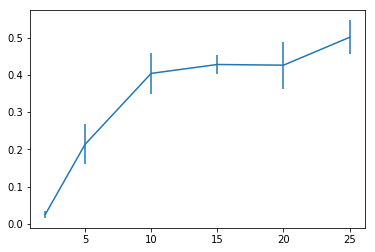

In [264]:
params = ['epochs', 'use_trans_model']
values = [20, 'True']
experiment_key = 'H1_num_steps=10'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std)

LinearEvalAcc [[0.31888571 0.3673     0.46996667 0.527675   0.4743     0.47875   ]]
FineTuning10pc30epochs [[0.41775714 0.6832     0.7265     0.822325   0.8083     0.84005   ]]
FineTuning10pc60epochs [[0.56402857 0.8306     0.87333333 0.896225   0.8294     0.90595   ]]
H1_num_steps=1 [[0.8361     0.96233333 0.976      0.98075    0.98125    0.983625  ]]
H1_num_steps=5 [[0.09915    0.44066667 0.591      0.67675    0.63625    0.714     ]]
H1_num_steps=10 [[0.0192     0.13908333 0.24983333 0.327      0.3055     0.379625  ]]
[[0.31888571 0.3673     0.46996667 0.527675   0.4743     0.47875   ]
 [0.41775714 0.6832     0.7265     0.822325   0.8083     0.84005   ]
 [0.56402857 0.8306     0.87333333 0.896225   0.8294     0.90595   ]
 [0.8361     0.96233333 0.976      0.98075    0.98125    0.983625  ]
 [0.09915    0.44066667 0.591      0.67675    0.63625    0.714     ]
 [0.0192     0.13908333 0.24983333 0.327      0.3055     0.379625  ]]


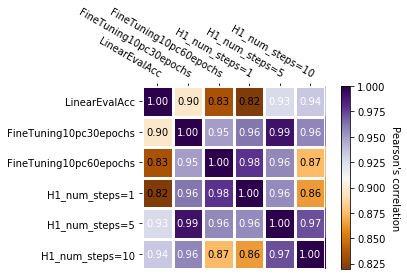

In [333]:
params = ['epochs', 'use_trans_model']
values = [20, 'True']
experiment_keys = ['LinearEvalAcc', 'FineTuning10pc30epochs', 'FineTuning10pc60epochs', 'H1_num_steps=1','H1_num_steps=5', 'H1_num_steps=10' ]
varying_param = 'num_objects'
corr_matrix = generate_pearson_corr_mat(results, params, values, experiment_keys, varying_param)

fig, ax = plt.subplots()

im, cbar = heatmap(corr_matrix, experiment_keys, experiment_keys, ax=ax,
                   cmap="PuOr", cbarlabel="Pearson's correlation")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

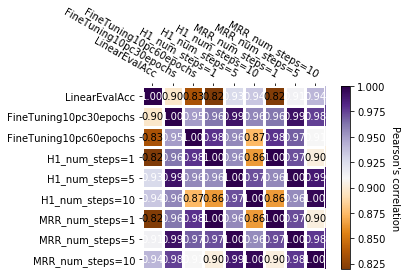

In [373]:
params = ['epochs', 'use_trans_model']
values = [10, 'True']
experiment_keys = ['LinearEvalAcc', 'FineTuning10pc30epochs', 'FineTuning10pc60epochs']
experiment_keys += ['H1_num_steps=1', 'H1_num_steps=5', 'H1_num_steps=10']
experiment_keys += ['MRR_num_steps=1', 'MRR_num_steps=5', 'MRR_num_steps=10']
varying_param = 'num_objects'
corr_matrix = generate_pearson_corr_mat(results, params, values, experiment_keys, varying_param)

fig, ax = plt.subplots()

im, cbar = heatmap(corr_matrix, experiment_keys, experiment_keys, ax=ax,
                   cmap="PuOr", cbarlabel="Pearson's correlation")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

In [407]:
params = ['epochs', 'use_trans_model']
values = [10, 'False']
experiment_keys = ['LinearEvalAcc', 'FineTuning10pc30epochs', 'FineTuning10pc60epochs']
varying_param = 'num_objects'
corr_matrix_0 = generate_results_mat(results, params, values, experiment_keys, varying_param)

params = ['epochs', 'use_trans_model']
values = [10, 'True']
experiment_keys = ['H1_num_steps=1', 'H1_num_steps=5', 'H1_num_steps=10']
experiment_keys += ['MRR_num_steps=1', 'MRR_num_steps=5', 'MRR_num_steps=10']
corr_matrix_1 = generate_results_mat(results, params, values, experiment_keys, varying_param)

corr_matrix = np.concatenate((corr_matrix_0, corr_matrix_1), axis=0)
corr_matrix = np.corrcoef(corr_matrix)

experiment_keys = ['LinearEvalAcc', 'FineTuning10pc30epochs', 'FineTuning10pc60epochs']
experiment_keys += ['H1_num_steps=1', 'H1_num_steps=5', 'H1_num_steps=10']
experiment_keys += ['MRR_num_steps=1', 'MRR_num_steps=5', 'MRR_num_steps=10']

p_c_c = [0.913, 0.985, 1.,  0.992,  0.977, 0.906, 0.993, 0.987, 0.937]
indexes = list(range(len(p_c_c)))
indexes.sort(key=p_c_c.__getitem__)
p_c_c = list(map(p_c_c.__getitem__, indexes))
experiment_keys = list(map(experiment_keys.__getitem__, indexes))
print(experiment_keys[::-1])
print(p_c_c[::-1])

['FineTuning10pc60epochs', 'MRR_num_steps=1', 'H1_num_steps=1', 'MRR_num_steps=5', 'FineTuning10pc30epochs', 'H1_num_steps=5', 'MRR_num_steps=10', 'LinearEvalAcc', 'H1_num_steps=10']
[1.0, 0.993, 0.992, 0.987, 0.985, 0.977, 0.937, 0.913, 0.906]


# Atari Variance

Problem and Solution:
- Results in the paper present high variance with 4 repetitions. We found different results
- Strangely : results with the ignore action flag are substatially better

//Training Atari Environment
- Episodes : 1000
- Steps: 10

- 200 epochs
- Batch = 1024
- Learning rate 5x10ˆ-4 
- Object slots tested: 1,3,5
- Object extractor: Two layer CNN
- Embedding dim = 4

//Evaluation:
- Episodes : 100
- Steps: 10


In [276]:
"""
Space Invaders
Results for:
!python train.py --dataset data/spaceinvaders_train.h5 --encoder medium --embedding-dim 4 --action-dim 6 --num-objects 3 --copy-action --epochs 200 --name spaceinvaders
!python eval.py --dataset data/spaceinvaders_eval.h5 --save-folder checkpoints/spaceinvaders --num-steps 1
"""
H1 = np.array([0.71, 0.59, 0.66, 0.55, 0.63, 0.74])
MRR = np.array([0.8336666666666664, 0.7565000000000001, 0.7981666666666668, 0.7081666666666666, 0.7806666666666666, 0.8514999999999999])

print("H1 = " + str(H1.mean()*100.0) + " +- " + str(H1.std()*100.0))
print("MRR = " + str(MRR.mean()*100.0) + " +- " + str(MRR.std()*100.0))

H1 = 64.66666666666666 +- 6.548960901462832
MRR = 78.8111111111111 +- 4.768013277800715


In [277]:
"""
Space Invaders ignore action
Results for:
python train.py --dataset data/spaceinvaders_train.h5 --encoder medium --embedding-dim 4 --action-dim 6 --num-objects 3 --copy-action --epochs 200 --name spaceinvaders --ignore-action
python eval.py --dataset data/spaceinvaders_eval.h5 --save-folder checkpoints/spaceinvaders --num-steps 1
"""
H1 = np.array([0.94, 0.79, 0.86, 0.94, 0.7])
MRR = np.array([0.9666666666666667, 0.8450396825396825, 0.9128571428571429,  0.9536025641025642, 0.7706955266955268])

print("H1 = " + str(H1.mean()*100.0) + " +- " + str(H1.std()*100.0))
print("MRR = " + str(MRR.mean()*100.0) + " +- " + str(MRR.std()*100.0))

H1 = 84.59999999999998 +- 9.2
MRR = 88.97723165723166 +- 7.307563371694354


In [278]:
"""
Pong
Results for: 
!python train.py --dataset data/pong_train.h5 --encoder medium --embedding-dim 4 --action-dim 6 --num-objects 3 --copy-action --epochs 200 --name pong
!python eval.py --dataset data/pong_eval.h5 --save-folder checkpoints/pong --num-steps 1
"""
H1 = np.array([0.45, 0.31, 0.17, 0.32, 0.45, 0.15])
MRR = np.array([0.6373849206349207, 0.5063095238095238, 0.42186904761904764, 0.5379567099567101, 0.6212539682539684, 0.37648051948051964])

print("H1 = " + str(H1.mean()*100.0) + " +- " + str(H1.std()*100.0))
print("MRR = " + str(MRR.mean()*100.0) + " +- " + str(MRR.std()*100.0))


H1 = 30.83333333333333 +- 11.866151674218376
MRR = 51.68757816257816 +- 9.549033014875477


# Basic MMNIST Results

In [193]:
#For hyper parameter search on MMNIST using ranking metrics
def extract_results_simple(file_path):
    file_list = []
    with open(file_path, "r") as f:
        for line in f:
            file_list.append(line[:-1])
    
    result_list = []
    i = -1
    temp_dict = None
    while i < len(file_list)-1:
        i += 1
        if len(file_list[i]) == 0:
            continue
        elif file_list[i][0:4] == '----':
            continue
        elif file_list[i][0:7] == "{'batch":
            if not temp_dict is None:
                result_list.append(temp_dict)
            #Get train parameters
            temp_dict = eval(file_list[i])
        elif file_list[i][0:5] == "{'H1'":
            num_steps = temp_dict['num_steps']
            res_steps_dict = eval(file_list[i])
            temp_dict['H1_num_steps='+str(num_steps)] = res_steps_dict['H1']
            temp_dict['MRR_num_steps='+str(num_steps)] = res_steps_dict['MRR'].item()
        else:
            print("Erro: entrada desconhecida:")
            print(file_list[i])
            print(i)

    return result_list

In [280]:
experiment_keys = ['H1_num_steps=1', 'H1_num_steps=5', 'H1_num_steps=10']
experiment_keys += ['MRR_num_steps=1', 'MRR_num_steps=5', 'MRR_num_steps=10']
varying_param = 'num_objects'
result_list = extract_results_simple("results/ranking_mmnist.txt")
ignore_keys = ['seed', 'num_reps', 'num_steps']
results = get_results_array(result_list, varying_param, experiment_keys, ignore_keys)

In [281]:
results

{"{'batch_size': 1024, 'epochs': 50, 'learning_rate': 0.0005, 'encoder': 'large', 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'embedding_dim': 30, 'action_dim': 4, 'ignore_action': True, 'copy_action': False, 'decoder': False, 'no_cuda': False, 'log_interval': 20, 'dataset': '/datasets/c_swm_data/mmnist_train.h5', 'name': 'mmnist', 'save_folder': 'checkpoints', 'dataset_eval': '/datasets/c_swm_data/mmnist_eval.h5', 'num_workers': 4, 'results_file': 'results_c_swm.txt', 'cuda': True}": {'H1_num_steps=1': {'result': [0.86125],
   'num_objects': [2]},
  'H1_num_steps=5': {'result': [], 'num_objects': []},
  'H1_num_steps=10': {'result': [], 'num_objects': []},
  'MRR_num_steps=1': {'result': [0.9058], 'num_objects': [2]},
  'MRR_num_steps=5': {'result': [], 'num_objects': []},
  'MRR_num_steps=10': {'result': [], 'num_objects': []}},
 "{'batch_size': 1024, 'epochs': 50, 'learning_rate': 0.0005, 'encoder': 'large', 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'embedding_dim': 10, 'act

<ErrorbarContainer object of 3 artists>

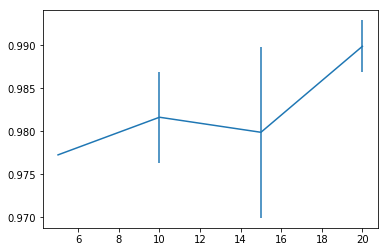

In [285]:
params = ['encoder', 'embedding_dim', 'batch_size']
values = ["large", 10, 1024]
experiment_key = 'H1_num_steps=1'
varying_param = 'num_objects'
x_objs, y_mean_objs, y_std_objs = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std)

In [235]:
params = ['encoder', 'embedding_dim', 'batch_size']
values = ["large", 10, 1024]
experiment_key = 'H1_num_steps=5'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
print(x, y_mean, y_std)

[20] [0.8346875] [0.011231060446369238]


In [236]:
params = ['encoder', 'embedding_dim', 'batch_size']
values = ["large", 10, 1024]
experiment_key = 'H1_num_steps=10'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
print(x, y_mean, y_std)

[20] [0.5347500000000001] [0.034399006768606945]


In [303]:
experiment_keys = ['H1_num_steps=1', 'H1_num_steps=5', 'H1_num_steps=10']
experiment_keys += ['MRR_num_steps=1', 'MRR_num_steps=5', 'MRR_num_steps=10']
varying_param = 'encoder'
result_list = extract_results_simple("results/ranking_mmnist.txt")
ignore_keys = ['seed', 'num_reps', 'num_steps']
results = get_results_array(result_list, varying_param, experiment_keys, ignore_keys)
results

{"{'batch_size': 1024, 'epochs': 50, 'learning_rate': 0.0005, 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'embedding_dim': 30, 'action_dim': 4, 'num_objects': 2, 'ignore_action': True, 'copy_action': False, 'decoder': False, 'no_cuda': False, 'log_interval': 20, 'dataset': '/datasets/c_swm_data/mmnist_train.h5', 'name': 'mmnist', 'save_folder': 'checkpoints', 'dataset_eval': '/datasets/c_swm_data/mmnist_eval.h5', 'num_workers': 4, 'results_file': 'results_c_swm.txt', 'cuda': True}": {'H1_num_steps=1': {'result': [0.86125],
   'encoder': ['large']},
  'H1_num_steps=5': {'result': [], 'encoder': []},
  'H1_num_steps=10': {'result': [], 'encoder': []},
  'MRR_num_steps=1': {'result': [0.9058], 'encoder': ['large']},
  'MRR_num_steps=5': {'result': [], 'encoder': []},
  'MRR_num_steps=10': {'result': [], 'encoder': []}},
 "{'batch_size': 1024, 'epochs': 50, 'learning_rate': 0.0005, 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'embedding_dim': 10, 'action_dim': 4, 'num_objects': 5, 'ig

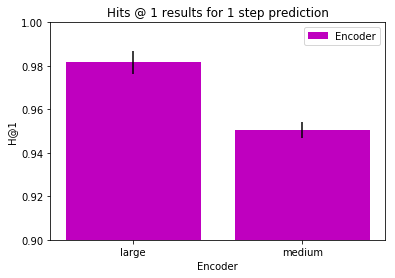

In [314]:
found_key = "{'batch_size': 1024, 'epochs': 50, 'learning_rate': 0.0005, 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'embedding_dim': 10, 'action_dim': 4, 'num_objects': 10, 'ignore_action': True, 'copy_action': False, 'decoder': False, 'no_cuda': False, 'log_interval': 20, 'dataset': '/datasets/c_swm_data/mmnist_train.h5', 'name': 'mmnist', 'save_folder': 'checkpoints', 'dataset_eval': '/datasets/c_swm_data/mmnist_eval.h5', 'num_workers': 4, 'results_file': 'results_c_swm.txt', 'cuda': True}"
experiment_key = 'H1_num_steps=1'
varying_param = 'encoder'
x, y_mean, y_std = get_mean_std_dev(results[found_key][experiment_key][varying_param], results[found_key][experiment_key]['result'])
plt.bar(x, y_mean, yerr=y_std, color='m', label='Encoder')
plt.xlabel('Encoder')
plt.ylabel('H@1')
plt.ylim(bottom=0.9, top=1.0)
plt.title('Hits @ 1 results for 1 step prediction')
plt.legend()
plt.show()

In [287]:
experiment_keys = ['H1_num_steps=1', 'H1_num_steps=5', 'H1_num_steps=10']
experiment_keys += ['MRR_num_steps=1', 'MRR_num_steps=5', 'MRR_num_steps=10']
varying_param = 'embedding_dim'
result_list = extract_results_simple("results/ranking_mmnist.txt")
ignore_keys = ['seed', 'num_reps', 'num_steps']
results = get_results_array(result_list, varying_param, experiment_keys, ignore_keys)
results

{"{'batch_size': 1024, 'epochs': 50, 'learning_rate': 0.0005, 'encoder': 'large', 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'action_dim': 4, 'num_objects': 2, 'ignore_action': True, 'copy_action': False, 'decoder': False, 'no_cuda': False, 'log_interval': 20, 'dataset': '/datasets/c_swm_data/mmnist_train.h5', 'name': 'mmnist', 'save_folder': 'checkpoints', 'dataset_eval': '/datasets/c_swm_data/mmnist_eval.h5', 'num_workers': 4, 'results_file': 'results_c_swm.txt', 'cuda': True}": {'H1_num_steps=1': {'result': [0.86125],
   'embedding_dim': [30]},
  'H1_num_steps=5': {'result': [], 'embedding_dim': []},
  'H1_num_steps=10': {'result': [], 'embedding_dim': []},
  'MRR_num_steps=1': {'result': [0.9058], 'embedding_dim': [30]},
  'MRR_num_steps=5': {'result': [], 'embedding_dim': []},
  'MRR_num_steps=10': {'result': [], 'embedding_dim': []}},
 "{'batch_size': 1024, 'epochs': 50, 'learning_rate': 0.0005, 'encoder': 'large', 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'action_dim': 

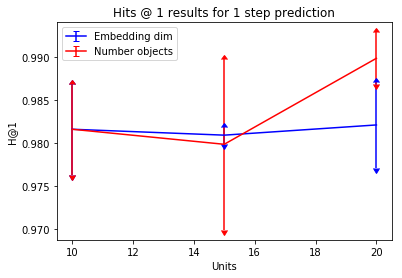

In [301]:
found_key = "{'batch_size': 1024, 'epochs': 50, 'learning_rate': 0.0005, 'encoder': 'large', 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'action_dim': 4, 'num_objects': 10, 'ignore_action': True, 'copy_action': False, 'decoder': False, 'no_cuda': False, 'log_interval': 20, 'dataset': '/datasets/c_swm_data/mmnist_train.h5', 'name': 'mmnist', 'save_folder': 'checkpoints', 'dataset_eval': '/datasets/c_swm_data/mmnist_eval.h5', 'num_workers': 4, 'results_file': 'results_c_swm.txt', 'cuda': True}"
experiment_key = 'H1_num_steps=1'
varying_param = 'embedding_dim'
x, y_mean, y_std = get_mean_std_dev(results[found_key][experiment_key][varying_param], results[found_key][experiment_key]['result'])
plt.errorbar(x, y_mean, yerr=y_std, color='b', label='Embedding dim', uplims=True, lolims=True)
plt.errorbar(x_objs[1:], y_mean_objs[1:], yerr=y_std_objs[1:], color='r', label='Number objects', uplims=True, lolims=True)
plt.xlabel('Units')
plt.ylabel('H@1')
plt.title('Hits @ 1 results for 1 step prediction')
plt.legend()
plt.show()

# Number of epochs 

One of the main goals of this section is to evaluate the correlation between ranking metrics and downstream task performance

In [410]:
experiment_keys = ['LinearEvalAcc', 'FineTuning10pc30epochs', 'FineTuning10pc60epochs']
experiment_keys += ['H1_num_steps=1', 'H1_num_steps=5', 'H1_num_steps=10']
experiment_keys += ['MRR_num_steps=1', 'MRR_num_steps=5', 'MRR_num_steps=10']
varying_param = 'epochs'
result_list = extract_results("results/eval_num_epochs.txt")
ignore_keys = ['seed']
results = get_results_array(result_list, varying_param, experiment_keys, ignore_keys)
results

{"{'batch_size': 512, 'learning_rate': 0.0005, 'encoder': 'large', 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'embedding_dim': 10, 'action_dim': 4, 'num_objects': 15, 'ignore_action': True, 'copy_action': False, 'decoder': False, 'no_cuda': False, 'log_interval': 20, 'dataset': '/datasets/c_swm_data/mmnist_train.h5', 'name': 'mmnist', 'save_folder': 'checkpoints', 'cuda': True, 'use_trans_model': 'False'}": {'LinearEvalAcc': {'result': [0.4827,
    0.4754,
    0.4482,
    0.3599,
    0.5399,
    0.5399,
    0.5571,
    0.4488,
    0.4911,
    0.4954,
    0.5286,
    0.4941,
    0.4082,
    0.4293,
    0.3501,
    0.5453,
    0.4606,
    0.4127,
    0.3065,
    0.5798,
    0.5618,
    0.4955,
    0.5299,
    0.4303,
    0.4858,
    0.4577,
    0.4889,
    0.3273,
    0.4124,
    0.5523,
    0.5413,
    0.6242,
    0.4556,
    0.5627],
   'epochs': [5,
    5,
    15,
    25,
    5,
    15,
    25,
    5,
    15,
    25,
    1,
    2,
    3,
    4,
    1,
    2,
    3,
    4,
    1,
 

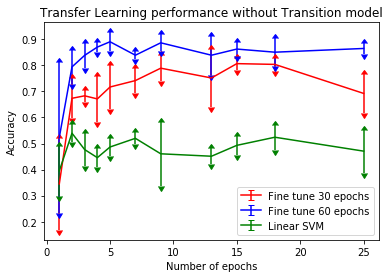

In [411]:
params = ['use_trans_model']
values = ['False']
varying_param = 'epochs'
#30 epochs
experiment_key = 'FineTuning10pc30epochs'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='r', label='Fine tune 30 epochs')
#60 epochs
experiment_key = 'FineTuning10pc60epochs'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='b', label='Fine tune 60 epochs')
#Linear eval
experiment_key = 'LinearEvalAcc'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='g', label='Linear SVM')

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Transfer Learning performance without Transition model')
plt.legend()
plt.show()

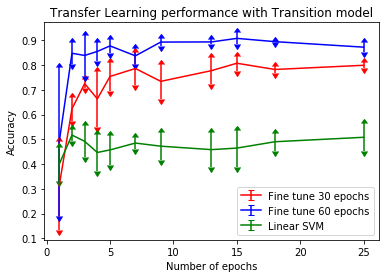

In [413]:
params = ['use_trans_model']
values = ['True']
varying_param = 'epochs'
#30 epochs
experiment_key = 'FineTuning10pc30epochs'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='r', label='Fine tune 30 epochs')
#60 epochs
experiment_key = 'FineTuning10pc60epochs'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='b', label='Fine tune 60 epochs')
#Linear eval
experiment_key = 'LinearEvalAcc'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='g', label='Linear SVM')

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Transfer Learning performance with Transition model')
plt.legend()
plt.show()

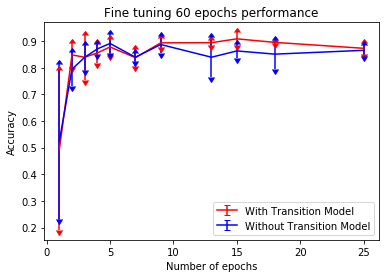

In [415]:
#With
params = ['use_trans_model']
values = ['True']
experiment_key = 'FineTuning10pc60epochs'
varying_param = 'epochs'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='r', label='With Transition Model')
#Without
params = ['use_trans_model']
values = ['False']
experiment_key = 'FineTuning10pc60epochs'
varying_param = 'epochs'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='b', label='Without Transition Model')


plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Fine tuning 60 epochs performance')
plt.legend()
plt.show()

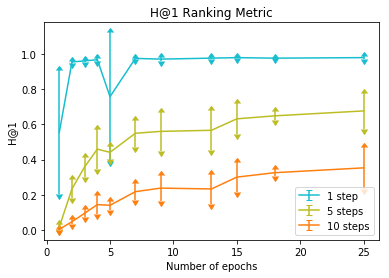

In [417]:
params = ['use_trans_model']
values = ['True']
#30 epochs
experiment_key = 'H1_num_steps=1'
varying_param = 'epochs'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='tab:cyan', label='1 step')
#60 epochs
experiment_key = 'H1_num_steps=5'
varying_param = 'epochs'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='tab:olive', label='5 steps')
#Linear eval
experiment_key = 'H1_num_steps=10'
varying_param = 'epochs'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='tab:orange', label='10 steps')

plt.xlabel('Number of epochs')
plt.ylabel('H@1')
plt.title('H@1 Ranking Metric')
plt.legend()
plt.show()

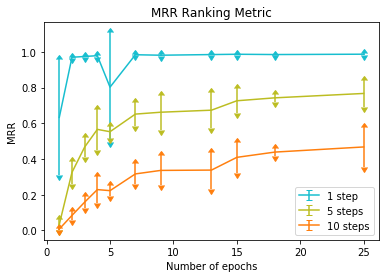

In [418]:
params = ['use_trans_model']
values = ['True']
#30 epochs
experiment_key = 'MRR_num_steps=1'
varying_param = 'epochs'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='tab:cyan', label='1 step')
#60 epochs
experiment_key = 'MRR_num_steps=5'
varying_param = 'epochs'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='tab:olive', label='5 steps')
#Linear eval
experiment_key = 'MRR_num_steps=10'
varying_param = 'epochs'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='tab:orange', label='10 steps')

plt.xlabel('Number of epochs')
plt.ylabel('MRR')
plt.title('MRR Ranking Metric')
plt.legend()
plt.show()

In [420]:
params = ['use_trans_model']
values = ['True']
experiment_keys = ['LinearEvalAcc', 'FineTuning10pc30epochs', 'FineTuning10pc60epochs']
varying_param = 'epochs'

experiment_keys = ['LinearEvalAcc', 'FineTuning10pc30epochs', 'FineTuning10pc60epochs']
experiment_keys += ['H1_num_steps=1', 'H1_num_steps=5', 'H1_num_steps=10']
experiment_keys += ['MRR_num_steps=1', 'MRR_num_steps=5', 'MRR_num_steps=10']

corr_matrix = generate_pearson_corr_mat(results, params, values, experiment_keys, varying_param)

corr_matrix = np.corrcoef(corr_matrix)

experiment_keys = ['LinearEvalAcc', 'FineTuning10pc30epochs', 'FineTuning10pc60epochs']
experiment_keys += ['H1_num_steps=1', 'H1_num_steps=5', 'H1_num_steps=10']
experiment_keys += ['MRR_num_steps=1', 'MRR_num_steps=5', 'MRR_num_steps=10']

p_c_c = corr_matrix[2]
indexes = list(range(len(p_c_c)))
indexes.sort(key=p_c_c.__getitem__)
p_c_c = list(map(p_c_c.__getitem__, indexes))
experiment_keys = list(map(experiment_keys.__getitem__, indexes))
print(experiment_keys[::-1])
print(p_c_c[::-1])

['FineTuning10pc60epochs', 'FineTuning10pc30epochs', 'H1_num_steps=1', 'MRR_num_steps=1', 'MRR_num_steps=5', 'H1_num_steps=5', 'LinearEvalAcc', 'MRR_num_steps=10', 'H1_num_steps=10']
[1.0, 0.7775354746163231, 0.6598699679924899, 0.6548064870017524, 0.280634983927455, 0.1557322784236676, 0.1285680860615844, -0.10006324524104629, -0.1798044115568872]


<ErrorbarContainer object of 3 artists>

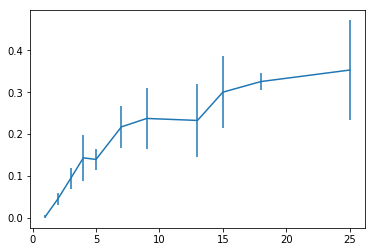

In [274]:
params = ['use_trans_model']
values = ['True']
experiment_key = 'H1_num_steps=10'
varying_param = 'epochs'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std)

In [275]:
params = ['use_trans_model']
values = ['True']
experiment_keys = ['LinearEvalAcc', 'FineTuning10pc30epochs', 'FineTuning10pc60epochs', 'H1_num_steps=1']
varying_param = 'epochs'
generate_pearson_corr_mat(results, params, values, experiment_keys, varying_param)

LinearEvalAcc [[0.4573     0.46463333 0.5083     0.40043333 0.5172     0.49196667
  0.4469     0.48493333 0.47233333 0.45843333 0.49025   ]]
FineTuning10pc30epochs [[0.75425    0.80756667 0.7993     0.31446667 0.62343333 0.72536667
  0.66356667 0.7863     0.73433333 0.77766667 0.7824    ]]
FineTuning10pc60epochs [[0.8777     0.9081     0.8726     0.49186667 0.8479     0.83906667
  0.85533333 0.8375     0.89313333 0.89373333 0.89485   ]]
H1_num_steps=1 [[0.75775    0.97983333 0.97991667 0.55491667 0.95541667 0.96116667
  0.96808333 0.97541667 0.97133333 0.97691667 0.97675   ]]
[[0.4573     0.46463333 0.5083     0.40043333 0.5172     0.49196667
  0.4469     0.48493333 0.47233333 0.45843333 0.49025   ]
 [0.75425    0.80756667 0.7993     0.31446667 0.62343333 0.72536667
  0.66356667 0.7863     0.73433333 0.77766667 0.7824    ]
 [0.8777     0.9081     0.8726     0.49186667 0.8479     0.83906667
  0.85533333 0.8375     0.89313333 0.89373333 0.89485   ]
 [0.75775    0.97983333 0.97991667 0.55

array([[1.        , 0.63396453, 0.66629951, 0.74008034],
       [0.63396453, 1.        , 0.93783988, 0.81468818],
       [0.66629951, 0.93783988, 1.        , 0.85977947],
       [0.74008034, 0.81468818, 0.85977947, 1.        ]])

#  SimCLR - NT-Xent Loss Function

In [423]:
experiment_keys = ['FineTuning10pc']
varying_param = 'epochs'
result_list = extract_results("results/eval_simclr_loss.txt")
ignore_keys = ['seed', 'eval_every']
results = get_results_array(result_list, varying_param, experiment_keys, ignore_keys)
results

{"{'batch_size': 512, 'learning_rate': 0.0005, 'encoder': 'large', 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'embedding_dim': 10, 'action_dim': 4, 'num_objects': 15, 'ignore_action': True, 'copy_action': False, 'decoder': False, 'no_cuda': False, 'log_interval': 20, 'dataset': '/datasets/c_swm_data/mmnist_train.h5', 'name': 'mmnist', 'save_folder': 'checkpoints', 'use_nt_xent_loss': True, 'temperature': 0.1, 'use_trans_model': 'False', 'padded_mnist_path': '/datasets/c_swm_data/padded_mnist.npz', 'num_workers': 4, 'results_file': 'eval_all_results.txt', 'cuda': True}": {'FineTuning10pc': {'result': [0.9248,
    0.9444,
    0.9306,
    0.9381,
    0.9414,
    0.9347,
    0.9348,
    0.9339,
    0.9417,
    0.9337,
    0.9371,
    0.9434,
    0.9217,
    0.935,
    0.9369,
    0.9409,
    0.938,
    0.9411,
    0.9397,
    0.9389,
    0.9382,
    0.9419,
    0.9376,
    0.9443,
    0.9269,
    0.9211,
    0.9398,
    0.9267,
    0.938,
    0.939,
    0.935,
    0.9375],
   'epochs':

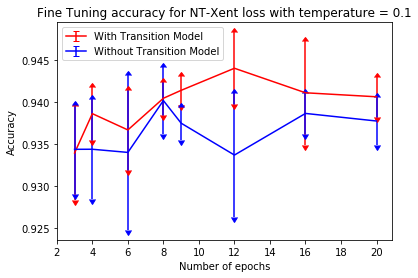

In [450]:
params = ['use_trans_model', 'use_nt_xent_loss', 'temperature']
values = ['True', True, 0.1]
varying_param = 'epochs'

experiment_key = 'FineTuning10pc'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='r', label='With Transition Model')

params = ['use_trans_model', 'use_nt_xent_loss', 'temperature']
values = ['False', True, 0.1]
varying_param = 'epochs'
experiment_key = 'FineTuning10pc'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='b', label='Without Transition Model')


plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.xticks(range(2,22,2))
plt.title('Fine Tuning accuracy for NT-Xent loss with temperature = 0.1')
plt.legend()
plt.show()

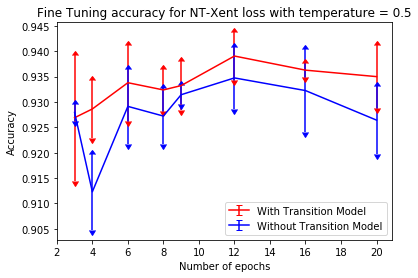

In [451]:
params = ['use_trans_model', 'use_nt_xent_loss', 'temperature']
values = ['True', True, 0.5]
varying_param = 'epochs'

experiment_key = 'FineTuning10pc'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='r', label='With Transition Model')

params = ['use_trans_model', 'use_nt_xent_loss', 'temperature']
values = ['False', True, 0.5]
varying_param = 'epochs'
experiment_key = 'FineTuning10pc'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='b', label='Without Transition Model')


plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.xticks(range(2,22,2))
plt.title('Fine Tuning accuracy for NT-Xent loss with temperature = 0.5')
plt.legend()
plt.show()

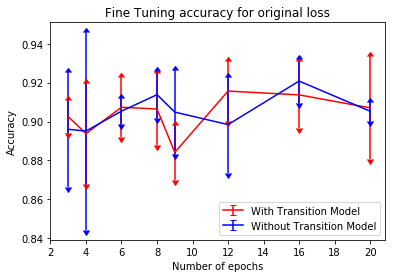

In [453]:
params = ['use_trans_model', 'use_nt_xent_loss', 'temperature']
values = ['True', False, 0.1]
varying_param = 'epochs'

experiment_key = 'FineTuning10pc'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='r', label='With Transition Model')

params = ['use_trans_model', 'use_nt_xent_loss', 'temperature']
values = ['False', False, 0.1]
varying_param = 'epochs'
experiment_key = 'FineTuning10pc'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='b', label='Without Transition Model')


plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.xticks(range(2,22,2))
plt.title('Fine Tuning accuracy for original loss')
plt.legend()
plt.show()

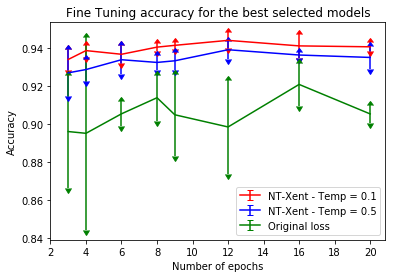

In [455]:
params = ['use_trans_model', 'use_nt_xent_loss', 'temperature']
values = ['True', True, 0.1]
varying_param = 'epochs'
#NT-Xent
experiment_key = 'FineTuning10pc'
x_false, y_mean_false, y_std_false = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x_false, y_mean_false, yerr=y_std_false, uplims=True, lolims=True, color='r', label='NT-Xent - Temp = 0.1')
#NT-Xent
params = ['use_trans_model', 'use_nt_xent_loss', 'temperature']
values = ['True', True, 0.5]
varying_param = 'epochs'
experiment_key = 'FineTuning10pc'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='b', label='NT-Xent - Temp = 0.5')
#Hinge Loss
params = ['use_trans_model', 'use_nt_xent_loss', 'temperature']
values = ['False', False, 0.1]
varying_param = 'epochs'
experiment_key = 'FineTuning10pc'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std, uplims=True, lolims=True, color='g', label='Original loss')


plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.xticks(range(2,22,2))
plt.title('Fine Tuning accuracy for the best selected models')
plt.legend()
plt.show()

# Data Augmentation

In [456]:
experiment_keys = ['FineTuning10pc']
varying_param = 'epochs'
result_list = extract_results("results/eval_da_sa.txt")
ignore_keys = ['seed', 'eval_every']
results = get_results_array(result_list, varying_param, experiment_keys, ignore_keys)
results

{"{'batch_size': 512, 'learning_rate': 0.0005, 'encoder': 'large', 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'embedding_dim': 10, 'action_dim': 4, 'num_objects': 15, 'ignore_action': True, 'copy_action': False, 'decoder': False, 'no_cuda': False, 'log_interval': 20, 'dataset': '/datasets/c_swm_data/mmnist_train.h5', 'name': 'mmnist', 'save_folder': 'checkpoints', 'use_nt_xent_loss': True, 'temperature': 0.1, 'use_trans_model': 'True', 'padded_mnist_path': '/datasets/c_swm_data/padded_mnist.npz', 'data_aug': True, 'num_workers': 4, 'results_file': 'eval_all_results.txt', 'cuda': True}": {'FineTuning10pc': {'result': [0.869,
    0.9279,
    0.9254,
    0.9573,
    0.9362,
    0.9461,
    0.954,
    0.9582,
    0.9616,
    0.9626],
   'epochs': [3, 6, 9, 12, 4, 8, 12, 16, 20, 24]}},
 "{'batch_size': 512, 'learning_rate': 0.0005, 'encoder': 'large', 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'embedding_dim': 10, 'action_dim': 4, 'num_objects': 15, 'ignore_action': True, 'copy_acti